In [1]:
import os
import zipfile
import string
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem.snowball import SnowballStemmer
from scipy.stats import uniform

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [3]:
sns.set(style='whitegrid')

## Unzip data

In [4]:
INPUT_PATH = 'data/input'
IMAGE_PATH = 'img'
zip_file = 'spooky-author-identification.zip'

In [5]:
for path in [INPUT_PATH, IMAGE_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
os.listdir(INPUT_PATH)

['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'train.csv']

In [7]:
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(INPUT_PATH)
#     os.remove()

In [8]:
os.listdir(INPUT_PATH)

['.ipynb_checkpoints',
 'sample_submission.csv',
 'sample_submission.zip',
 'test.csv',
 'test.zip',
 'train.csv',
 'train.zip']

In [9]:
for filename in os.listdir(INPUT_PATH):
    if filename.endswith('.zip'):
        with zipfile.ZipFile(f'{INPUT_PATH}/{filename}', 'r') as zip_ref:
            zip_ref.extractall(INPUT_PATH)
        os.remove(f'{INPUT_PATH}/{filename}')

In [10]:
os.listdir(INPUT_PATH)

['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'train.csv']

## Read data

In [11]:
df = pd.read_csv(f'{INPUT_PATH}/train.csv', index_col='id')

In [12]:
df.shape

(19579, 2)

In [13]:
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


## Feature engineering and text processing

In [14]:
# lowercase
df['processed'] = df['text'].apply(lambda x: x.lower())

In [15]:
# count chars and words
df['n_chars'] = df['processed'].apply(lambda x: len(x))
df['n_words'] = df['processed'].apply(lambda x: len(x.split(' ')))

In [16]:
# count punctuation marks
df['n_punctuation'] = df['processed'].apply(lambda x: len([dig for dig in list(x) if dig in string.punctuation]))

In [17]:
# remove punctuation marks
df['processed'] = df['processed'].apply(lambda x: ''.join(ch for ch in x if ch not in string.punctuation))

In [18]:
df.head()

,text,author,processed,n_chars,n_words,n_punctuation
id,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,231,41,7
id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,71,14,1
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,200,36,5
id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,206,34,4
id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,174,27,4


In [19]:
# count nouns, adjetives and verbs
nouns = ('NN','NNP','NNPS','NNS')
adjectives = ('JJ','JJR','JJS')
verbs = ('VB','VBD','VBG','VBN','VBP','VBZ')

df['n_noun'] = df['processed'].apply(lambda x: sum(np.in1d(np.array(pos_tag(word_tokenize(x)))[:,1], nouns)))
df['n_adj'] = df['processed'].apply(lambda x: sum(np.in1d(np.array(pos_tag(word_tokenize(x)))[:,1], adjectives)))
df['n_verb'] = df['processed'].apply(lambda x: sum(np.in1d(np.array(pos_tag(word_tokenize(x)))[:,1], verbs)))

In [20]:
# count stopwords
eng_stopwords = set(stopwords.words("english"))
df['n_stopwords'] = df['processed'].apply(lambda x: sum(np.in1d(word_tokenize(x), eng_stopwords)))

In [21]:
# unique words
df['n_unique'] = df['processed'].apply(lambda x: len(set(word_tokenize(x))))

In [22]:
# fractions

for count in ['n_noun', 'n_adj', 'n_verb', 'n_stopwords', 'n_unique']:
    df['fract'+count[1:]] = df[count] / df['n_words']
    
df['fract_punctuation'] = df['n_punctuation']/df['n_chars']

In [23]:
df.head()

,text,author,processed,n_chars,n_words,n_punctuation,n_noun,n_adj,n_verb,n_stopwords,n_unique,fract_noun,fract_adj,fract_verb,fract_stopwords,fract_unique,fract_punctuation
id,,,,,,,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,231,41,7,12,2,6,0,35,0.292683,0.048780,0.146341,0.0,0.853659,0.030303
id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,71,14,1,2,1,2,0,14,0.142857,0.071429,0.142857,0.0,1.000000,0.014085
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,200,36,5,10,5,4,0,32,0.277778,0.138889,0.111111,0.0,0.888889,0.025000
id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,206,34,4,10,6,5,0,31,0.294118,0.176471,0.147059,0.0,0.911765,0.019417
id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,174,27,4,6,1,6,0,25,0.222222,0.037037,0.222222,0.0,0.925926,0.022989


## EDA

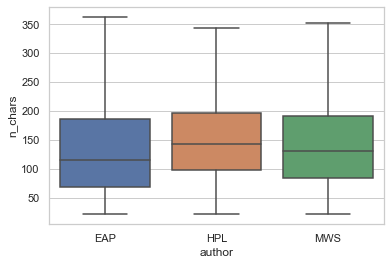

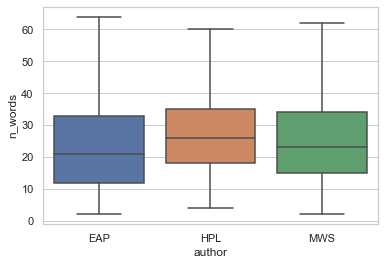

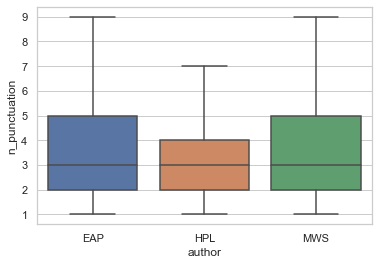

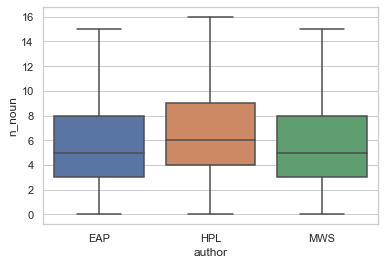

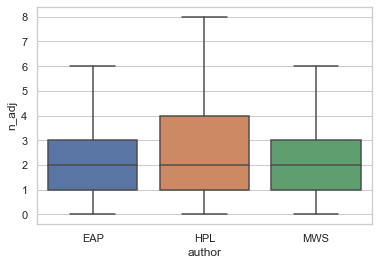

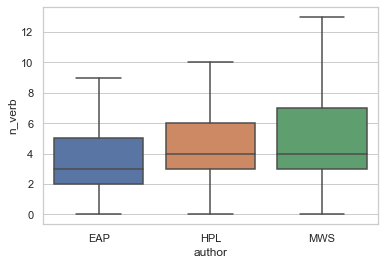

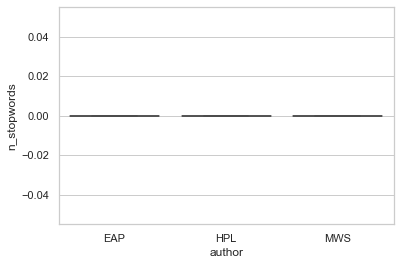

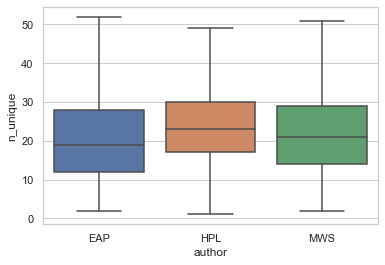

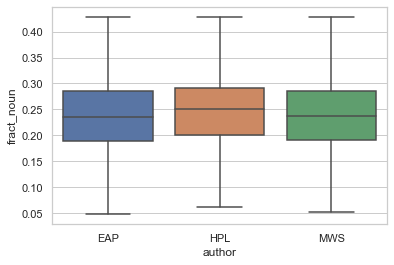

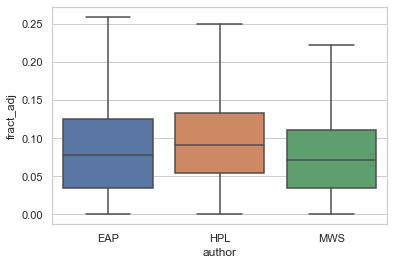

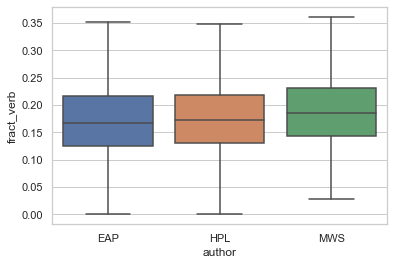

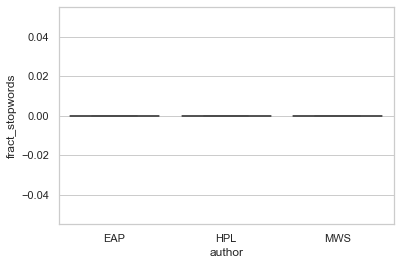

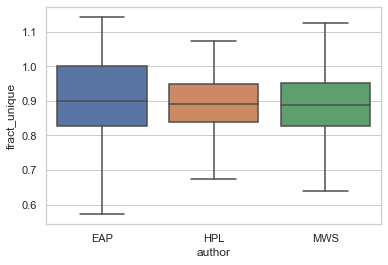

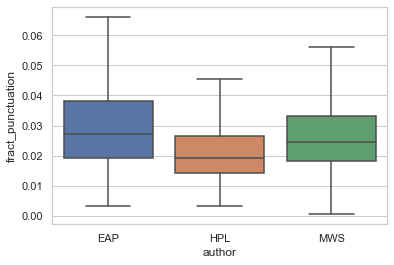

In [24]:
for col in list(df.columns[df.columns.get_loc('n_chars'):]):
    sns.boxplot(x='author', y=col, data=df, showfliers=False)
    plt.show()
    plt.close()

In [25]:
def show_word_cloud(s, author='', save=True):
    text = " ".join(review for review in s)
    # Create stopword list:
    stopwords = set(eng_stopwords)

    # Generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.figure(figsize=(13, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(author)
    plt.show()
    if save:
#         plt.savefig(f"img/word_cloud{author}.jpg", format="jpg",dpi=100)
        wordcloud.to_file(f"{IMAGE_PATH}/word_cloud{author}.png")
    plt.close()

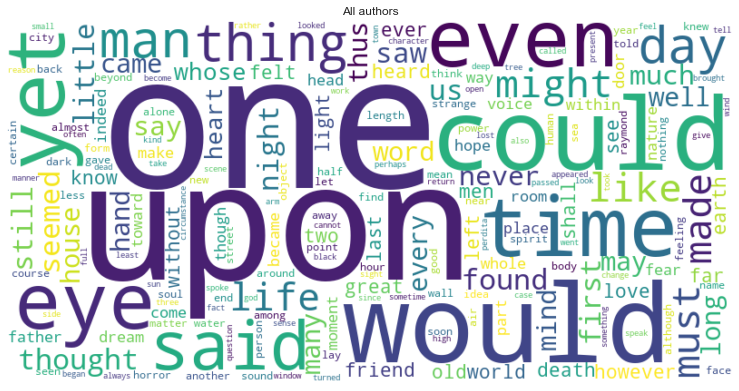

In [26]:
show_word_cloud(df['processed'], 'All authors')

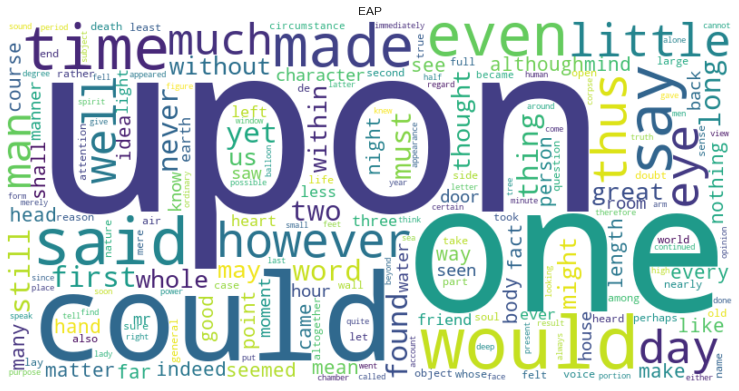

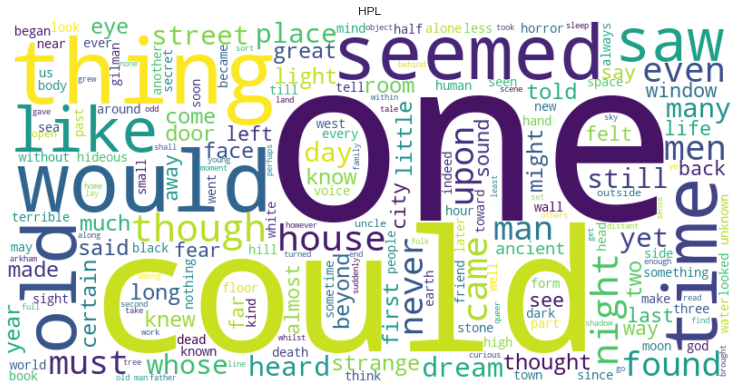

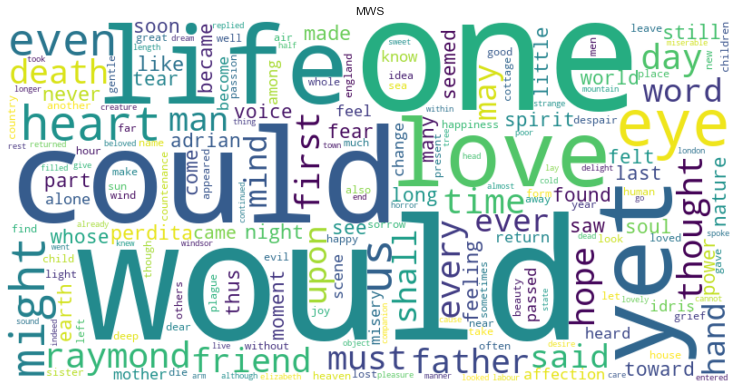

In [27]:
for author in df['author'].unique():
    show_word_cloud(df[df['author'] == author]['processed'], author)

## Stemming

In [28]:
stemmer=SnowballStemmer("english")

def stem(s):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(s)])

%time df['processed'] = df['processed'].apply(lambda x: stem(x))

Wall time: 10.6 s


## Train/test split

In [29]:
train_cols = list(df.columns[df.columns.get_loc('processed'):])
X, y = df[train_cols].copy(), df['author'].copy()

In [30]:
# text_pipe = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words=eng_stopwords)),
# #     ('decompose', TSNE(n_components=2, random_state=42, verbose=False)),
# ])

# %time X = np.concatenate([X, text_pipe.fit_transform(X['processed'])], axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = X_train.copy()
X_test = X_test.copy()

In [32]:
# # text_pipe = TfidfVectorizer(stop_words=eng_stopwords)
# %time text_pipe.fit(X_train['processed'])
# %time X_train = np.concatenate([X_train, text_pipe.transform(X_train['processed'])], axis=1)
# %time X_test = np.concatenate([X_test, text_pipe.transform(X_test['processed'])], axis=1)

## TF-IDF

In [33]:
tfidf = TfidfVectorizer(stop_words=eng_stopwords, min_df=3)
tfidf.fit(X_train['processed'])
X_train = np.concatenate([X_train, tfidf.transform(X_train['processed']).toarray()], axis=1)
X_test = np.concatenate([X_test, tfidf.transform(X_test['processed']).toarray()], axis=1)

In [34]:
X_train.shape

(13117, 6805)

In [35]:
X_train, X_test = X_train[:, 1:], X_test[:, 1:]

In [36]:
gs = GridSearchCV(
    MultinomialNB(),
    param_grid = { 'alpha':(0.001, 0.01,0.05, 0.1, 0.5, 1, 10)},
    scoring='neg_log_loss',
    n_jobs = 1,
    cv=4,
    verbose=100,
    refit=True
)
gs.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=0.001 .....................................................


KeyboardInterrupt: 

In [ ]:
nb = gs.best_estimator_
nb

In [ ]:
accuracy_score(y_test, nb.predict(X_test))

In [ ]:
# search_params = {
#     'max_depth': [i for i in range(20, 1000)],
#     'min_samples_split': [i for i in range(2, 20)],
#     'min_samples_leaf': [i for i in range(1, 20)],
#     'max_features': uniform(loc=0.01, scale =0.4),
#     'max_samples': uniform(loc=0.2, scale =0.8)
# #     'max_leaf_nodes': [i for i in range(2, 100)],
# }

# rs = RandomizedSearchCV(
#     RandomForestClassifier(n_estimators = 5, random_state=42, n_jobs=-1),
#     search_params,
#     n_iter=30,
#     scoring='neg_log_loss',
#     n_jobs = 1,
#     cv=3,
#     verbose=100,
#     refit=False,
#     random_state=42
# )
# rs.fit(X_train, y_train)

In [ ]:
rf_params = dict(max_depth=710, max_features=0.0225716742746937,
                       max_samples=0.7091283290110244, min_samples_leaf=4,
                       min_samples_split=6)
rf_params['n_estimators'] = 200
rf_params['random_state'] = 42
rf_params['n_jobs'] = -1
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, rf.predict(X_test))

In [ ]:
svm_pipe= Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC(max_iter=1200, random_state=42))
])

%time svm_pipe.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, svm_pipe.predict(X_test))

In [ ]:
vote_clf = VotingClassifier(
    estimators = [
        ('nb', nb),
        ('rf', rf),
        ('svm', svm_pipe)
    ],
#     final_estimator=LogisticRegression(),
    n_jobs=-1,
#     cv=3,
#     verbose=10
)
vote_clf.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, vote_clf.predict(X_test))

In [ ]:
vote_clf.estimators_

In [ ]:
for clf in [nb, rf, svm_pipe, vote_clf]:
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

In [ ]:
df.shape